# Text Classification using Decision forests and pretrained embedding

In the example we will use gradient boosted with pretrained embedding to classify disaster-related tweets.

url: https://keras.io/examples/nlp/tweet-classification-using-tfdf/

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt

## Get the data

Files is from a csv

In [28]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/IMvision12/Tweets-Classification-NLP/main/train.csv"
)

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [29]:
print(f"Training dataset shape: {df.shape}")

Training dataset shape: (7613, 5)


Next we will need to shuffle and drop the unnecessary columns

In [30]:
df_shuffled = df.sample(frac=1, random_state=42)

# dropping of id, keyword and location columns as these columns consists of nan values
df_shuffled.drop(["id", "keyword", "location"], axis=1, inplace=True)
df_shuffled.reset_index(inplace=True, drop=True)


In [31]:
df_shuffled.head()

,text,target
0,So you have a new weapon that can cause un-ima...,1
1,The f$&amp;@ing things I do for #GISHWHES Just...,0
2,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
3,Aftershock back to school kick off was great. ...,0
4,in response to trauma Children of Addicts deve...,0


Printing information about the shuffled dataframe

In [32]:
print(df_shuffled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB
None


Total number of disaster and non-disaster tweets

In [33]:
print(
    "Total number of disaster and non disaster tweets: "
    f"{df_shuffled.target.value_counts()}"
)

Total number of disaster and non disaster tweets: 0    4342
1    3271
Name: target, dtype: int64


Need to preview a few samples:

In [34]:
for index, example in df_shuffled[:5].iterrows():
    print(f"Example ${index}")
    print(f"\tTarget : {example['target']}")
    print(f"\tText : {example['text']}")

Example $0
	Target : 1
	Text : So you have a new weapon that can cause un-imaginable destruction.
Example $1
	Target : 0
	Text : The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@
Example $2
	Target : 1
	Text : DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q
Example $3
	Target : 0
	Text : Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.
Example $4
	Target : 0
	Text : in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3


splitting dataset into training and test set

In [35]:
test_df = df_shuffled.sample(frac=0.1, random_state=42)
train_df = df_shuffled.drop(test_df.index)

In [36]:
print(f"Using {len(train_df)} sample for training and {len(test_df)} for validation")

Using 6852 sample for training and 761 for validation


Total number of "disaster" and "non disaster" tweets in the training data

In [37]:
print(train_df["target"].value_counts())

0    3929
1    2923
Name: target, dtype: int64


## Convert data to tf.data.dataset

In [38]:
def create_dataset(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].to_numpy(), dataframe["target"].to_numpy())
    )
    dataset = dataset.batch(100)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [39]:
train_ds = create_dataset(train_df)
test_ds = create_dataset(test_df)

### Downloading pretrained embedding

Universal sentence encoder embedding encode text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language task. 

They trained on a variety of data sources and variety of tasks. Their input is variable-length english text and their output is a 512 dimensinal vector

In [40]:
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4"
)

2023-01-05 20:09:54.858376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Creating our models

We will be creating two models. 

The first model (model_1) raw text will be first encoded via pretrained embedding and then passed to a gradient boosted tree model for classification. 

The second model (model_2) raw text will be directly passed to the gradient boosted tree model

Building model 1

In [41]:
inputs = layers.Input(shape=(), dtype=tf.string)
outputs = sentence_encoder_layer(inputs)
preprocessor = keras.Model(inputs=inputs, outputs=outputs)
model_1 = tfdf.keras.GradientBoostedTreesModel(preprocessing=preprocessor)

Use /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmp600ki07e as temporary training directory


Build model 2

In [42]:
model_2 = tfdf.keras.GradientBoostedTreesModel()

Use /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmp80es5bos as temporary training directory


### Train the models

We will compile our models by passing the metrics Accuracy, Recall, Precision and AUC. 

When it comes to loss, tfdf automatically detects the best loss for the task (classification or regression). Then is printed in the model summary.

Due to the batch training models rather than mini-batch gradient descent models, tfdf models do not need validation dataset to monitor overfitting, or to stop training early. 



In [43]:
# compiling model_1
model_1.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])

model_1.fit(train_ds)

Reading training dataset...


2023-01-05 20:09:59.620911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training dataset read in 0:00:18.275766. Found 6852 examples.
Training model...
Model trained in 0:00:22.709118
Compiling model...


[INFO kernel.cc:1176] Loading model from path /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmp600ki07e/model/ with prefix 447656fe4e7941a6
[INFO abstract_model.cc:1249] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1022] Use fast generic engine
2023-01-05 20:10:40.682456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model compiled.


2023-01-05 20:10:45.451129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [44]:
model_2.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])

model_2.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:00.278228. Found 6852 examples.
Training model...


2023-01-05 20:10:45.702610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model trained in 0:00:00.118663
Compiling model...
Model compiled.


[INFO kernel.cc:1176] Loading model from path /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmp80es5bos/model/ with prefix 9f981351071f4edb
[INFO kernel.cc:1022] Use fast generic engine
2023-01-05 20:10:46.026390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-05 20:10:46.045761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Printing the logs for model 1

In [45]:
logs_1 = model_1.make_inspector().training_logs()

print(logs_1)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.5656716227531433, loss=1.3077609539031982, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.6865671873092651, loss=1.2614209651947021, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.7417910695075989, loss=1.2177786827087402, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.7701492309570312, loss=1.1783922910690308, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.7776119112968445, loss=1.1459333896636963, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.7835820913314819, loss=1.1136521100997925, rmse=None, n

Print the logs for model 2

In [46]:
logs_2 = model_2.make_inspector().training_logs()

print(logs_2)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.5656716227531433, loss=1.3685380220413208, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3679413795471191, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3674567937850952, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3670554161071777, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3667176961898804, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.366430401802063, rmse=None, nd

Model.summary() will print a variety of information about your decision tree model

including model type, task, input features and feature importance

In [47]:
print("Model 1 summary")
print(model_1.summary())

Model 1 summary
Model: "gradient_boosted_trees_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 512)               256797824 
                                                                 
Total params: 256,797,825
Trainable params: 0
Non-trainable params: 256,797,825
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (512):
	model_1/keras_layer_1/StatefulPartitionedCall:0.0
	model_1/keras_layer_1/StatefulPartitionedCall:0.1
	model_1/keras_layer_1/StatefulPartitionedCall:0.10
	model_1/keras_layer_1/StatefulPartitionedCall:0.100
	model_1/keras_layer_1/StatefulPartitionedCall:0.101
	model_1/keras_layer_1/StatefulPartitionedCall:0.102
	model_1/keras_layer_1/StatefulPartitionedCall:0.103
	model_1/keras_layer_1/StatefulPartitionedCall:0.104
	model_1/keras_layer_1/

In [48]:
print("model 2 summary")
print(model_2.summary())

model 2 summary
Model: "gradient_boosted_trees_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (1):
	data:0

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  2.250000 ################
    2.  "data:0"  0.000000 

Variable Importance: NUM_AS_ROOT:
    1. "data:0" 117.000000 

Variable Importance: NUM_NODES:
    1. "data:0" 351.000000 

Variable Importance: SUM_SCORE:
    1. "data:0" 32.035971 



Loss: BINOMIAL_LOG_LIKELIHOOD
Validation loss value: 1.36429
Number of trees per iteration: 1
Node format: NOT_SET
Number of trees: 117
Total number of nodes: 819

Number of nodes by tree:
Count: 117 Average: 7 StdDev: 0
Min: 7 Max: 7 Ignored: 0
---------------------------------

### Plotting training metrics

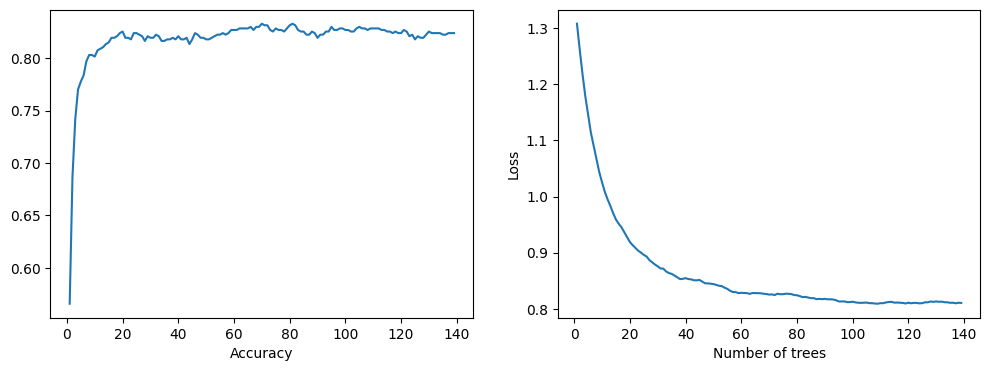

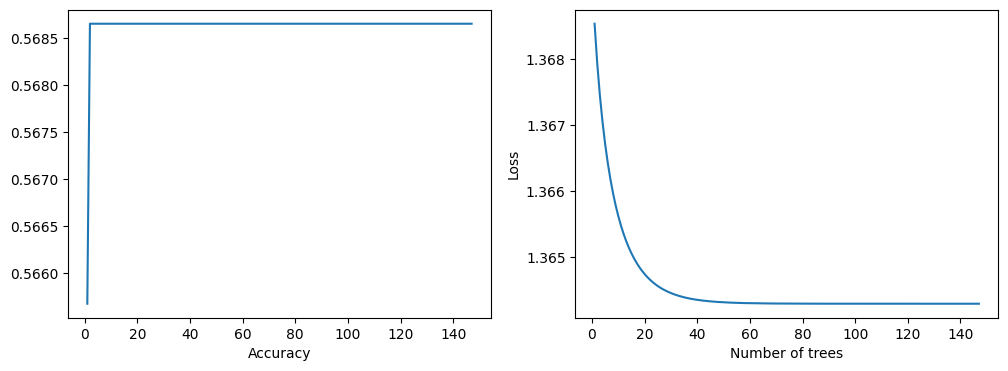

In [49]:
def plot_curve(logs):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.xlabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")

    plt.show()

plot_curve(logs_1)
plot_curve(logs_2)

### Evaluating on test data

In [51]:
results = model_1.evaluate(test_ds, return_dict=True, verbose=0)
print("model 1 evauation: \n")
for name, value in results.items():
    print(f"{name}: {value:.4f}")

2023-01-05 20:11:41.832132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


model 1 evauation: 

loss: 0.0000
Accuracy: 0.8147
recall: 0.7213
precision: 0.8508
auc: 0.8710


In [52]:
results_2 = model_2.evaluate(test_ds, return_dict=True, verbose=0)
print("model 2 evaluation: \n")
for name, value in results_2.items():
    print(f"{name}: {value:.4f}")

2023-01-05 20:15:10.138116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


model 2 evaluation: 

loss: 0.0000
Accuracy: 0.5440
recall: 0.0029
precision: 1.0000
auc: 0.5026


### Predicting on validation data

In [53]:
test_df.reset_index(inplace=True, drop=True)
for index, row in test_df.iterrows():
    text = tf.expand_dims(row["text"], axis=0)
    preds = model_1.predict_step(text)
    preds = tf.squeeze(tf.round(preds))
    print(f"Text: {row['text']}")
    print(f"prediction: {int(preds)}")
    print(f"Ground truth: {row['target']}")
    if index == 10:
        break

2023-01-05 20:19:33.151856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Text: DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5
prediction: 0
Ground truth: 0
Text: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday
prediction: 1
Ground truth: 0
Text: Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj
prediction: 1
Ground truth: 1
Text: @camilacabello97 Internally and externally screaming
prediction: 0
Ground truth: 1
Text: Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov
prediction: 1
Ground truth: 1
Text: Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8
prediction: 1
Ground truth: 1
Text: How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #